In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import zipfile
import os

def unzip_folder(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)


zip_path = '/content/drive/MyDrive/Dataset (1).zip'
extract_to = '/content'
unzip_folder(zip_path,extract_to)

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (500,500)
batch_size = 1
seed = 42
class_names = [
    "Interacting with computer",
    "Photographing",
    "Playing Instrument",
    "Riding Bike",
    "Riding Horse",
    "Running",
    "Walking"
]
dataset_path = "/content/Dataset"

print("Training set:")
train_set = image_dataset_from_directory(
    directory=dataset_path + "/TrainSet",
    labels="inferred",
    label_mode="categorical",
    #class_names=class_names,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    crop_to_aspect_ratio=False,
    validation_split=0.12,
    subset="validation",
    seed=seed
)



Training set:
Found 420 files belonging to 7 classes.
Using 50 files for validation.


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


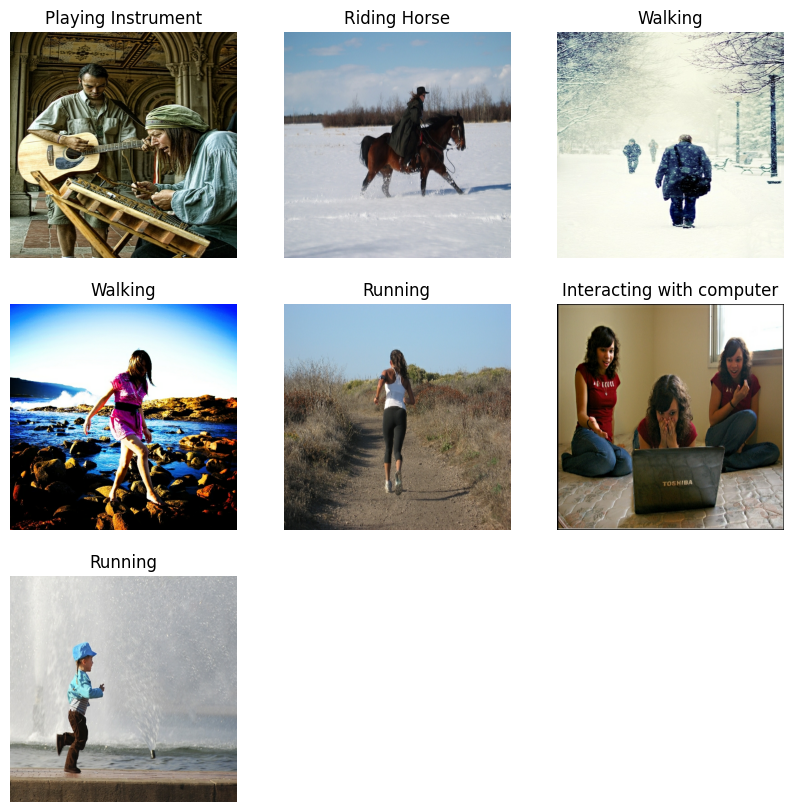

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_set.take(len(class_names)):
    lbl=labels.numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    lbl_idx = [i for i in range(len(lbl[0])) if lbl[0][i] != 0][0]
    plt.title(class_names[lbl_idx])
    plt.axis("off")
    i+=1

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from time import time
from datetime import timedelta
import random

def createCNN(input_shape, nb_classes):
    nb_filters = 32
    filter_size = (3, 3)
    max_pooling_size = (2, 2)
    inner_dropout_ratio = 0.4
    output_dropout_ratio = 0.2
    kernel_regularizer = l2(0.01)
    kernel_initializer="he_normal"
    random.seed(seed)


    model = Sequential()

    model.add(Conv2D(nb_filters, filter_size, padding='same', activation='relu',
                     kernel_initializer=kernel_initializer,
                     input_shape=input_shape, name="Conv2D_1"))

    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_1"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_1"))


    model.add(Conv2D(nb_filters*2, filter_size, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer, name="Conv2D_3"))

    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_2"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_2"))

    model.add(Conv2D(nb_filters*2, filter_size, padding='same', activation='relu',
                     kernel_regularizer=kernel_regularizer, name="Conv2D_5"))

    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_3"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_3"))


    flat_layer = Flatten()
    model.add(flat_layer)
    dense_size = model.output_shape[1]
    model.add(Dense(512, activation='relu', name="Dense_1"))

    model.add(Dropout(output_dropout_ratio, name="Dropout_4"))

    model.add(Dense(nb_classes, activation='softmax', name="Predictions"))

    return model

input_shape = train_set.element_spec[0].shape[1:]
nb_classes = train_set.element_spec[1].shape[1]
model = createCNN(input_shape, nb_classes)

feature_extractor = Model(
    inputs=model.inputs,

    outputs=model.get_layer(name="Conv2D_1").output,
)

In [8]:
X = train_set
y = []
features = None
for element in X:
    y.append(model(element[0]))
    features = feature_extractor(element[0])
    break

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Conv2D_1 (Conv2D)                    │ (None, 500, 500, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DownSampling_1 (MaxPooling2D)        │ (None, 250, 250, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_1 (Dropout)                  │ (None, 250, 250, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 250, 250, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DownSampling_2 (MaxPooling2D)        │ (None, 125, 125, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_2 (Dropout)                  │ (None, 125, 125, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_5 (Conv2D)                    │ (None, 125, 125, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ DownSampling_3 (MaxPooling2D)        │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_3 (Dropout)                  │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 512)                 │     125,960,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Predictions (Dense)                  │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,020,615 (480.73 MB)

 Trainable params: 126,020,615 (480.73 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Optimizer
optimizer = RMSprop()
# Loss fuction to minimize
loss = CategoricalCrossentropy()
# Metrics to monitor
metrics = [CategoricalAccuracy()]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

print(f"Mean accuracy of {np.mean(history.history['categorical_accuracy']):.3f}, mean validation accuracy of {np.mean(history.history['val_categorical_accuracy']):.3f}")

# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

print(f"Mean loss of {np.mean(history.history['loss']):.3f}, mean validation loss of {np.mean(history.history['val_loss']):.3f}")

In [ ]:
time_start = time()
model.evaluate(test_set)
elapsed_time = time() - time_start
print(f"Testing time: {timedelta(seconds=elapsed_time)}.")

In [ ]:
from tensorflow.math import confusion_matrix
from tensorflow import concat
from seaborn import heatmap

from tensorflow.keras.models import load_model
model = load_model('./models/model_350x350_50_32.h5')

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

predictions = model.predict(test_set)
predicted_labels = argmax(predictions, axis=-1)
target_labels = concat([label for img, label in test_set], axis=0)
target_labels = argmax(target_labels, axis=-1) # 1D

conf_matrix = confusion_matrix(predictions=predicted_labels, labels=target_labels, num_classes=len(class_names))
show_confusion_matrix(conf_matrix, test_set.class_names)

In [ ]:
from tensorflow.math import confusion_matrix
from tensorflow import concat
from seaborn import heatmap

from tensorflow.keras.models import load_model
model = load_model('./models/model_350x350_50_32.h5')

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  heatmap(cm, xticklabels=labels, yticklabels=labels,
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

predictions = model.predict(test_set)
predicted_labels = argmax(predictions, axis=-1)
target_labels = concat([label for img, label in test_set], axis=0)
target_labels = argmax(target_labels, axis=-1) # 1D

conf_matrix = confusion_matrix(predictions=predicted_labels, labels=target_labels, num_classes=len(class_names))
show_confusion_matrix(conf_matrix, test_set.class_names)

In [ ]:
batch_size = 32 # 32, 64, 256
epochs = 50 # 50, 100
time_start = time()
history = model.fit(train_set, epochs=epochs,
                    batch_size=batch_size, verbose=1,
                    validation_data=val_set)
elapsed_time = time() - time_start
print(f"Training time: {timedelta(seconds=elapsed_time)}.")

In [ ]:
model.save(
    filepath="./models/model_" + str(image_size[0]) + "x" + str(image_size[1]) + "_" +
    str(epochs) + "_" + str(batch_size) + ".h5",
    overwrite=False,
)
